In [206]:
!pip install numpy opencv-python matplotlib pandas
import numpy as np
import cv2 as cv
from glob import glob
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Calibration images:

In [208]:
base_path = '/content/drive/MyDrive/PROJETO VC/ASSIGNMENT 1/assign1_data'

# Array com os padrões glob (como querias)
calib_folders = [
    f'{base_path}/Calibration/calib1/*.png',
    f'{base_path}/Calibration/calib2/*.png',
    f'{base_path}/Calibration/calib3/*.png'
]

In [209]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# If 12x9 squares, 11x8 inner corners
PATTERN_SIZE = (11, 8)
SQUARE_SIZE = 15  # mm

objp = np.zeros((PATTERN_SIZE[0] * PATTERN_SIZE[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:PATTERN_SIZE[0], 0:PATTERN_SIZE[1]].T.reshape(-1, 2)
objp *= SQUARE_SIZE  # Scale by actual square size

## a)

In [210]:
# Dictionary to store all calibration results
calibration_results = {}

for folder_pattern in calib_folders:
    objpoints_temp = []
    imgpoints_temp = []

    images = glob(folder_pattern)

    for fname in images:
        img = cv.imread(fname)

        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find chessboard corners
        ret, corners = cv.findChessboardCorners(
            gray,
            PATTERN_SIZE,
            cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE
        )

        if ret:
            objpoints_temp.append(objp)
            # Refine corner positions to subpixel accuracy
            corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints_temp.append(corners2)

    # Calibrate if corners were found
    if len(objpoints_temp) > 0:
        ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
            objpoints_temp,
            imgpoints_temp,
            gray.shape[::-1],
            None,
            None
        )

        # Calculate reprojection error
        mean_error = 0
        for i in range(len(objpoints_temp)):
            imgpoints2, _ = cv.projectPoints(objpoints_temp[i], rvecs[i], tvecs[i], mtx, dist)
            error = cv.norm(imgpoints_temp[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
            mean_error += error

        reprojection_error = mean_error / len(objpoints_temp)

        # Store results
        calib_name = folder_pattern.split('/')[-2]  # Extract 'calib1', 'calib2', etc.
        calibration_results[calib_name] = {
            'mtx': mtx,
            'dist': dist,
            'rvecs': rvecs,
            'tvecs': tvecs,
            'reprojection_error': reprojection_error,
            'num_images': len(objpoints_temp)
        }

        print(f"\n{'='*50}")
        print(f"Calibration Results for {folder_pattern}")
        print(f"{'='*50}")
        print(f"\nIntrinsic Matrix (K):")
        print(mtx)
        print(f"\nDistortion Coefficients (k1, k2, p1, p2, k3):")
        print(dist)
        print(f"\nReprojection Error: {reprojection_error:.4f} pixels")
        print(f"{'='*50}\n")


cv.destroyAllWindows()



Calibration Results for /content/drive/MyDrive/PROJETO VC/ASSIGNMENT 1/assign1_data/Calibration/calib1/*.png

Intrinsic Matrix (K):
[[827.57846603   0.         334.83393114]
 [  0.         827.43749445 281.31040705]
 [  0.           0.           1.        ]]

Distortion Coefficients (k1, k2, p1, p2, k3):
[[-0.43653613  0.40330684 -0.00135039  0.00154944 -0.53357973]]

Reprojection Error: 0.0404 pixels


Calibration Results for /content/drive/MyDrive/PROJETO VC/ASSIGNMENT 1/assign1_data/Calibration/calib2/*.png

Intrinsic Matrix (K):
[[839.07613864   0.         339.34165725]
 [  0.         839.32227716 276.31089839]
 [  0.           0.           1.        ]]

Distortion Coefficients (k1, k2, p1, p2, k3):
[[-4.32166093e-01  2.83162024e-01 -2.23953393e-04  4.15173862e-04
  -1.38440678e-01]]

Reprojection Error: 0.0074 pixels


Calibration Results for /content/drive/MyDrive/PROJETO VC/ASSIGNMENT 1/assign1_data/Calibration/calib3/*.png

Intrinsic Matrix (K):
[[837.55334665   0.         338

## Best Calibration Selection


In [211]:
# Find calibration with lowest reprojection error
best_calib = min(calibration_results.items(),
                 key=lambda x: x[1]['reprojection_error'])
best_calib_name = best_calib[0]
best_calib_data = best_calib[1]

# Load the best intrinsic calibration results
mtx = best_calib_data['mtx']
dist = best_calib_data['dist']

print("\n" + "="*60)
print("BEST CALIBRATION SELECTION")
print()
print(f"Reprojection Error: {best_calib_data['reprojection_error']:.4f} pixels")
print()
print("Intrinsic Matrix (K):")
print(mtx)
print("\nDistortion Coefficients:")
print(dist)
print()


BEST CALIBRATION SELECTION

Reprojection Error: 0.0074 pixels

Intrinsic Matrix (K):
[[839.07613864   0.         339.34165725]
 [  0.         839.32227716 276.31089839]
 [  0.           0.           1.        ]]

Distortion Coefficients:
[[-4.32166093e-01  2.83162024e-01 -2.23953393e-04  4.15173862e-04
  -1.38440678e-01]]



After comparing the three calibration datasets, **calib2** was selected as the best calibration based on the lowest reprojection error (0.0074 pixels).

## b)


EXTRINSIC CALIBRATION RESULTS

Extrinsic Matrix [R|t] (3x4):
[[-9.98391200e-01 -1.22530188e-02 -5.53613199e-02  6.41626142e+01]
 [ 8.67550580e-03 -9.97886105e-01  6.44054112e-02  3.56702439e+01]
 [-5.60334526e-02  6.38215083e-02  9.96387007e-01  2.66735075e+02]]

PIXEL-TO-MILLIMETER CONVERSION
  Pixel distance between corners: 45.49 px
  Actual distance: 15 mm
  Conversion factor: 0.3298 mm/pixel



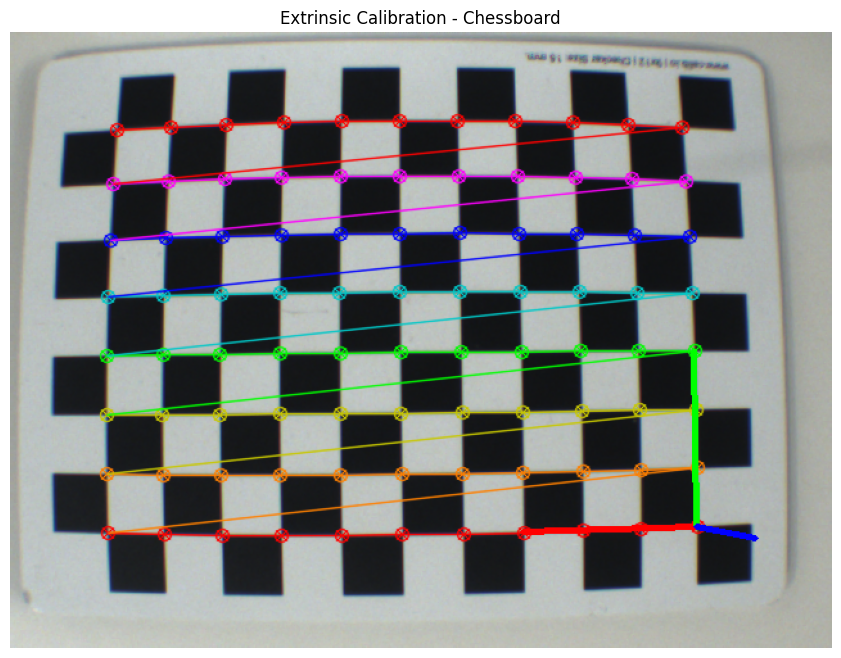

In [212]:
# Load the final setup image
img = cv.imread(f'{base_path}/Calibration/final_setup.png')

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Find chessboard corners
ret, corners = cv.findChessboardCorners(
    gray,
    PATTERN_SIZE,
    cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE
)

corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
success, rvec, tvec = cv.solvePnP(objp, corners2, mtx, dist)

if success:
    R, _ = cv.Rodrigues(rvec)

    # Construct the extrinsic matrix [R|t] (3x4)
    extrinsic_matrix = np.hstack((R, tvec))

    print("\n" + "="*60)
    print("EXTRINSIC CALIBRATION RESULTS")
    print("="*60)
    print("\nExtrinsic Matrix [R|t] (3x4):")
    print(extrinsic_matrix)

    # Calculate pixel-to-millimeter conversion factor
    corner1 = corners2[0].flatten()
    corner2 = corners2[PATTERN_SIZE[0]].flatten()

    pixel_distance = np.linalg.norm(corner1 - corner2)
    actual_distance_mm = SQUARE_SIZE  # mm

    mm_per_pixel = actual_distance_mm / pixel_distance

    print("\n" + "="*60)
    print("PIXEL-TO-MILLIMETER CONVERSION")
    print("="*60)
    print(f"  Pixel distance between corners: {pixel_distance:.2f} px")
    print(f"  Actual distance: {actual_distance_mm} mm")
    print(f"  Conversion factor: {mm_per_pixel:.4f} mm/pixel")

    print("\n" + "="*60)

    #Visualize detected corners
    img_corners = img.copy()
    cv.drawChessboardCorners(img_corners, PATTERN_SIZE, corners2, ret)

    # Draw coordinate axes on the image
    axis_length = 3 * SQUARE_SIZE  # 3 squares length
    axis = np.float32([[axis_length, 0, 0],
                        [0, axis_length, 0],
                        [0, 0, -axis_length]]).reshape(-1, 3)

    imgpts, _ = cv.projectPoints(axis, rvec, tvec, mtx, dist)
    origin, _ = cv.projectPoints(np.float32([[0, 0, 0]]), rvec, tvec, mtx, dist)

    origin = tuple(origin[0].ravel().astype(int))
    img_corners = cv.line(img_corners, origin, tuple(imgpts[0].ravel().astype(int)), (0, 0, 255), 3)  # X-axis (red)
    img_corners = cv.line(img_corners, origin, tuple(imgpts[1].ravel().astype(int)), (0, 255, 0), 3)  # Y-axis (green)
    img_corners = cv.line(img_corners, origin, tuple(imgpts[2].ravel().astype(int)), (255, 0, 0), 3)  # Z-axis (blue)

    # Convert BGR to RGB for matplotlib
    img_corners_rgb = cv.cvtColor(img_corners, cv.COLOR_BGR2RGB)

    # Plot the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_corners_rgb)
    plt.title('Extrinsic Calibration - Chessboard')
    plt.axis('off')
    plt.show()

## 2. Isolated brick images:

In [213]:
image_files = [
    f'{base_path}/Isolated/colored_bricks.png',
    f'{base_path}/Isolated/blue.png',
    f'{base_path}/Isolated/yellow.png',
    f'{base_path}/Isolated/green.png',
    f'{base_path}/Isolated/red.png'
]

## a)

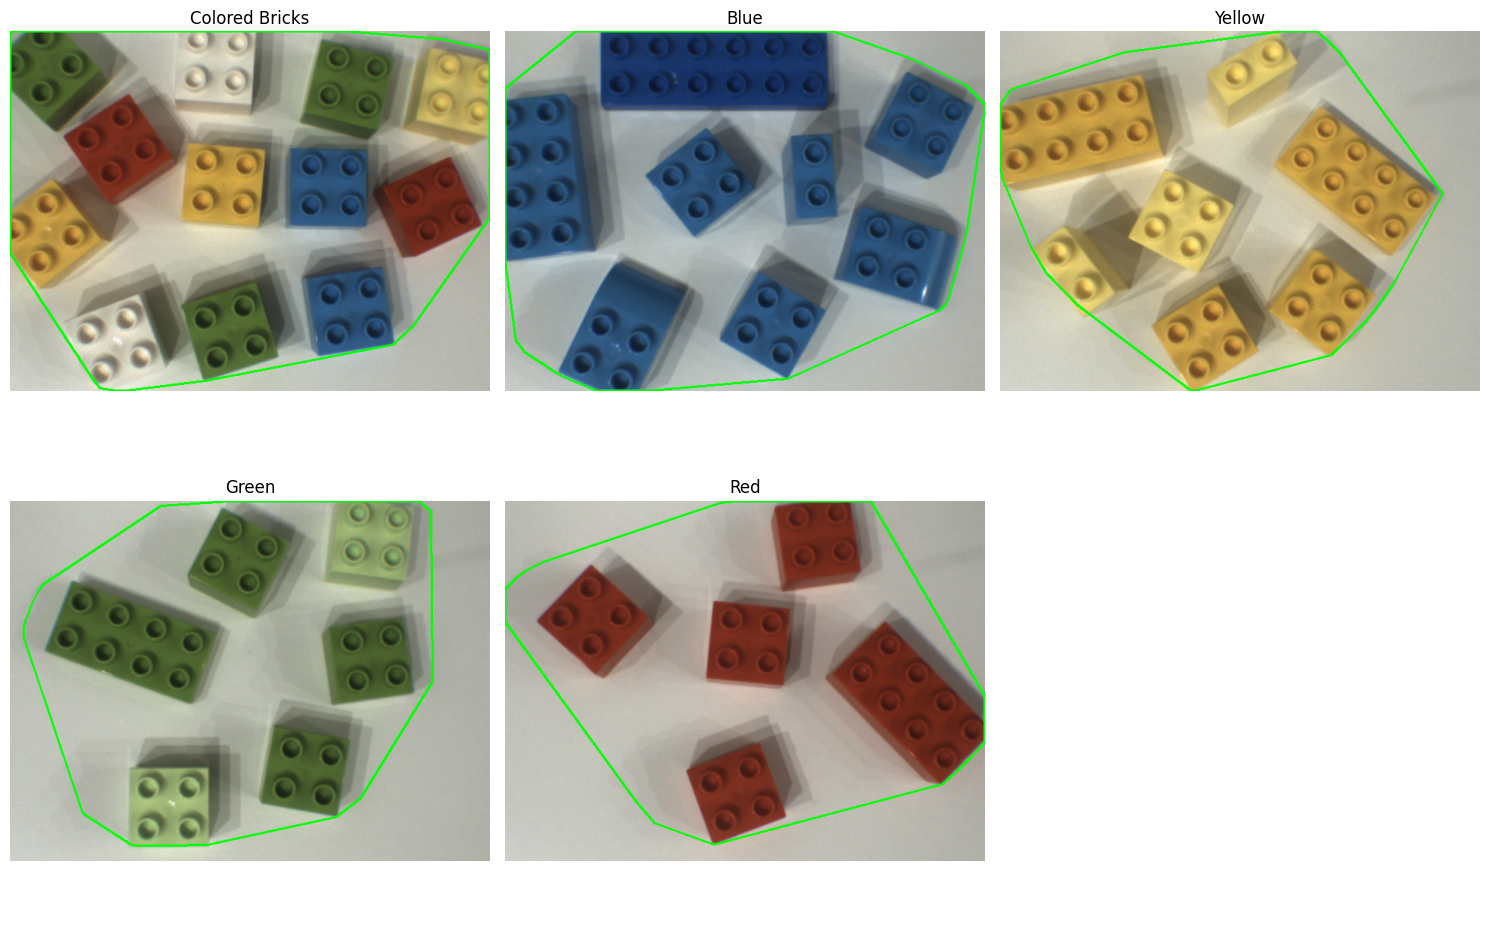

In [214]:
# Load and undistort the background image
background_img = cv.imread(f'{base_path}/Calibration/background.png')
undistorted_bg = cv.undistort(background_img, mtx, dist, None, mtx)

images_with_roi = []
titles = ['Colored Bricks', 'Blue', 'Yellow', 'Green', 'Red']

for img_path in image_files:

    img = cv.imread(img_path)
    undistorted_img = cv.undistort(img, mtx, dist, None, mtx)

    diff = cv.absdiff(undistorted_img, undistorted_bg)
    gray_diff = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray_diff, 25, 255, cv.THRESH_BINARY)

    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if contours:

        all_points = np.vstack(contours)
        hull = cv.convexHull(all_points)

        img_with_hull = undistorted_img.copy()
        cv.drawContours(img_with_hull, [hull], 0, (0, 255, 0), 2)

        images_with_roi.append(img_with_hull)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (img, title) in enumerate(zip(images_with_roi, titles)):
    axes[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    axes[i].set_title(title)
    axes[i].axis('off')
axes[5].axis('off')

plt.tight_layout()
plt.show()


## b)

In [215]:
# Load and undistort the main image
img = cv.imread(image_files[0])
undistorted_img = cv.undistort(img, mtx, dist, None, mtx)

# Background subtraction
diff = cv.absdiff(undistorted_img, undistorted_bg)

gray_diff = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)
_, foreground_mask = cv.threshold(gray_diff, 25, 255, cv.THRESH_BINARY)

# Apply morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
foreground_mask = cv.morphologyEx(foreground_mask, cv.MORPH_CLOSE, kernel)
foreground_mask = cv.morphologyEx(foreground_mask, cv.MORPH_OPEN, kernel)


hsv = cv.cvtColor(undistorted_img, cv.COLOR_BGR2HSV)

# Define HSV color ranges for colored bricks
color_ranges = {
    'Red': [(0, 100, 100), (10, 255, 255)],
    'Red2': [(170, 100, 100), (180, 255, 255)],
    'Yellow': [(20, 100, 100), (30, 255, 255)],
    'Green': [(40, 50, 50), (80, 255, 255)],
    'Blue': [(90, 50, 50), (130, 255, 255)],
}

brick_counts = {}

result_img = undistorted_img.copy()
all_colored_mask = np.zeros(foreground_mask.shape, dtype=np.uint8)

# Process each colored brick type
for color_name, (lower, upper) in color_ranges.items():
    # Create mask for this color
    lower_bound = np.array(lower)
    upper_bound = np.array(upper)
    color_mask = cv.inRange(hsv, lower_bound, upper_bound)

    # Combine with foreground mask
    color_mask = cv.bitwise_and(color_mask, foreground_mask)

    # Apply morphological operations
    color_mask = cv.morphologyEx(color_mask, cv.MORPH_CLOSE, kernel)
    color_mask = cv.morphologyEx(color_mask, cv.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv.findContours(color_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    min_area = 500
    valid_contours = [c for c in contours if cv.contourArea(c) > min_area]

    if color_name == 'Red':
        brick_counts['Red'] = len(valid_contours)
    elif color_name == 'Red2':
        brick_counts['Red'] = brick_counts.get('Red', 0) + len(valid_contours)
    else:
        brick_counts[color_name] = len(valid_contours)


    cv.drawContours(result_img, valid_contours, -1, (0, 255, 0), 2)
    cv.drawContours(all_colored_mask, valid_contours, -1, 255, -1)


white_mask = cv.bitwise_and(foreground_mask, cv.bitwise_not(all_colored_mask))

kernel_larger = np.ones((7, 7), np.uint8)
white_mask = cv.morphologyEx(white_mask, cv.MORPH_CLOSE, kernel_larger)
white_mask = cv.morphologyEx(white_mask, cv.MORPH_OPEN, kernel_larger)
white_contours, _ = cv.findContours(white_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

min_white_area = 800
white_valid_contours = []

for contour in white_contours:
    area = cv.contourArea(contour)
    if area > min_white_area:
        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0

        if 0.5 <= aspect_ratio <= 2.0:
            white_valid_contours.append(contour)

brick_counts['White'] = len(white_valid_contours)
cv.drawContours(result_img, white_valid_contours, -1, (0, 255, 0), 2)

# Print results
print("Brick Count by Color:")
print("-" * 30)
for color, count in brick_counts.items():
    if color != 'Red2':
        print(f"{color}: {count} brick(s)")
print(f"\nTotal: {sum(brick_counts.values()) - brick_counts.get('Red2', 0)} bricks")



Brick Count by Color:
------------------------------
Red: 2 brick(s)
Yellow: 3 brick(s)
Green: 3 brick(s)
Blue: 2 brick(s)
White: 2 brick(s)

Total: 12 bricks


## c)

In [216]:
BRICK_DIMENSIONS = {
    '2x1': {'length': 32, 'width': 15, 'area': 480},
    '2x2': {'length': 32, 'width': 32, 'area': 1024},
    '2x4': {'length': 32, 'width': 64, 'area': 2048},
    '2x6': {'length': 32, 'width': 95, 'area': 3040},
    'R2x2': {'length': 32, 'width': 47, 'area': 1504}
}

color_ranges = {
    'blue': [[(90, 50, 50), (130, 255, 255)]],
    'yellow': [[(15, 50, 50), (35, 255, 255)]],
    'green': [[(40, 50, 50), (80, 255, 255)]],
    'red': [[(0, 100, 100), (10, 255, 255)], [(170, 100, 100), (180, 255, 255)]]
}

MIN_AREA = {
    'blue': 8000,
    'yellow': 1000,
    'green': 8000,
    'red': 8000
}

image_files = [
    (f'{base_path}/Isolated/blue.png', 'blue'),
    (f'{base_path}/Isolated/yellow.png', 'yellow'),
    (f'{base_path}/Isolated/green.png', 'green'),
    (f'{base_path}/Isolated/red.png', 'red')
]


In [217]:
all_areas_by_color = defaultdict(list)

for img_path, color_name in image_files:
    img = cv.imread(img_path)
    undistorted_img = cv.undistort(img, mtx, dist, None, mtx)

    diff = cv.absdiff(undistorted_img, undistorted_bg)
    gray_diff = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)
    _, foreground_mask = cv.threshold(gray_diff, 25, 255, cv.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    foreground_mask = cv.morphologyEx(foreground_mask, cv.MORPH_CLOSE, kernel)
    foreground_mask = cv.morphologyEx(foreground_mask, cv.MORPH_OPEN, kernel)

    hsv = cv.cvtColor(undistorted_img, cv.COLOR_BGR2HSV)

    color_mask = np.zeros(foreground_mask.shape, dtype=np.uint8)
    for lower, upper in color_ranges[color_name]:
        temp_mask = cv.inRange(hsv, lower, upper)
        color_mask = cv.bitwise_or(color_mask, temp_mask)

    color_mask = cv.bitwise_and(color_mask, foreground_mask)
    color_mask = cv.morphologyEx(color_mask, cv.MORPH_CLOSE, kernel)
    color_mask = cv.morphologyEx(color_mask, cv.MORPH_OPEN, kernel)

    contours, _ = cv.findContours(color_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    min_area = MIN_AREA[color_name]

    for contour in contours:
        area_pixels = cv.contourArea(contour)

        if area_pixels > min_area:
            x, y, w, h = cv.boundingRect(contour)
            aspect_ratio = float(max(w, h)) / float(min(w, h)) if min(w, h) > 0 else 0

            if aspect_ratio <= 3.5:
                all_areas_by_color[color_name].append(area_pixels)


all_areas = []
for areas in all_areas_by_color.values():
    all_areas.extend(areas)

all_areas = sorted(all_areas)
medium_areas = [a for a in all_areas if 9000 < a < 13000]

if medium_areas:
    reference_area_pixels = np.mean(medium_areas)
    pixel_to_mm_squared = BRICK_DIMENSIONS['2x2']['area'] / reference_area_pixels
else:
    reference_area_pixels = 11500
    pixel_to_mm_squared = BRICK_DIMENSIONS['2x2']['area'] / reference_area_pixels

brick_sizes_all = defaultdict(list)

for img_path, color_name in image_files:
    img = cv.imread(img_path)
    undistorted_img = cv.undistort(img, mtx, dist, None, mtx)

    diff = cv.absdiff(undistorted_img, undistorted_bg)
    gray_diff = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)
    _, foreground_mask = cv.threshold(gray_diff, 25, 255, cv.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    foreground_mask = cv.morphologyEx(foreground_mask, cv.MORPH_CLOSE, kernel)
    foreground_mask = cv.morphologyEx(foreground_mask, cv.MORPH_OPEN, kernel)

    hsv = cv.cvtColor(undistorted_img, cv.COLOR_BGR2HSV)

    color_mask = np.zeros(foreground_mask.shape, dtype=np.uint8)
    for lower, upper in color_ranges[color_name]:
        temp_mask = cv.inRange(hsv, lower, upper)
        color_mask = cv.bitwise_or(color_mask, temp_mask)

    color_mask = cv.bitwise_and(color_mask, foreground_mask)
    color_mask = cv.morphologyEx(color_mask, cv.MORPH_CLOSE, kernel)
    color_mask = cv.morphologyEx(color_mask, cv.MORPH_OPEN, kernel)

    contours, _ = cv.findContours(color_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    min_area = MIN_AREA[color_name]
    color_bricks = []

    for contour in contours:
        area_pixels = cv.contourArea(contour)

        if area_pixels > min_area:
            x, y, w, h = cv.boundingRect(contour)
            aspect_ratio = float(max(w, h)) / float(min(w, h)) if min(w, h) > 0 else 0

            if aspect_ratio <= 3.5:
                area_mm = area_pixels * pixel_to_mm_squared

                # Classify
                min_diff = float('inf')
                best_size = '2x2'

                for size, dims in BRICK_DIMENSIONS.items():
                    diff_area = abs(area_mm - dims['area'])
                    if diff_area < min_diff:
                        min_diff = diff_area
                        best_size = size

                color_bricks.append({
                    'area_pixels': area_pixels,
                    'area_mm': area_mm,
                    'size': best_size
                })
                brick_sizes_all[best_size].append(area_pixels)

# Final Table
print("\n" + "="*90)
print("Table 2: Result table for question 2c")
print("="*90)
print(f"{'Size':<10} {'Avg Area (pixel)':<20} {'Avg Area (mm)':<20} {'Standard deviation (mm)':<25}")
print("-"*90)

for size in sorted(brick_sizes_all.keys()):
    areas_pixels = np.array(brick_sizes_all[size])

    if len(areas_pixels) > 0:
        avg_area_pixels = np.mean(areas_pixels)
        areas_mm = areas_pixels * pixel_to_mm_squared
        avg_area_mm = np.mean(areas_mm)
        std_dev_mm = np.std(areas_mm)

        print(f"{size:<10} {avg_area_pixels:<20.2f} {avg_area_mm:<20.2f} {std_dev_mm:<25.2f}")



Table 2: Result table for question 2c
Size       Avg Area (pixel)     Avg Area (mm)        Standard deviation (mm)  
------------------------------------------------------------------------------------------
2x1        4574.50              409.58               228.53                   
2x2        11436.79             1024.00              72.88                    
2x4        22367.67             2002.70              104.91                   
2x6        34159.33             3058.48              495.34                   
R2x2       17187.12             1538.86              116.09                   


## 3. Kit images:

In [218]:
def classify_brick_size(width_mm, length_mm):
    """
    Classify brick size based on dimensions from Table 1
    Uses normalized dimensions (always larger dimension first)
    """
    # Standard dimensions from Table 1
    sizes = {
        '2x1': (32, 15),   # length x width
        '2x2': (32, 32),
        '2x4': (64, 32),
        '2x6': (95, 32),
        'R2x2': (47, 32)
    }

    # Normalize: larger dimension first
    dim1 = max(width_mm, length_mm)
    dim2 = min(width_mm, length_mm)

    tolerance = 10.5 # mm
    best_match = None
    min_error = float('inf')

    for size_name, (expected_dim1, expected_dim2) in sizes.items():
        # Also normalize expected dimensions
        exp_dim1 = max(expected_dim1, expected_dim2)
        exp_dim2 = min(expected_dim1, expected_dim2)

        # Calculate error
        error1 = abs(dim1 - exp_dim1)
        error2 = abs(dim2 - exp_dim2)
        total_error = error1 + error2

        if error1 <= tolerance and error2 <= tolerance and total_error < min_error:
            min_error = total_error
            best_match = size_name

    return best_match if best_match else 'Unknown'


def analyze_kit_image_with_rotation(image_path, mtx, dist, color_ranges, mm_per_pixel, detect_white=False):
    """
    Analyze kit image handling rotated bricks using minAreaRect
    detect_white: set to True only if you need to detect white bricks
    """
    # Load and undistort
    img = cv.imread(image_path)
    if img is None:
        return None, None, []

    undistorted_img = cv.undistort(img, mtx, dist, None, mtx)
    hsv = cv.cvtColor(undistorted_img, cv.COLOR_BGR2HSV)
    result_img = undistorted_img.copy()

    # Initialize inventory
    brick_inventory = {
        '2x1': {'Red': 0, 'Yellow': 0, 'Green': 0, 'Blue': 0, 'White': 0},
        '2x2': {'Red': 0, 'Yellow': 0, 'Green': 0, 'Blue': 0, 'White': 0},
        '2x4': {'Red': 0, 'Yellow': 0, 'Green': 0, 'Blue': 0, 'White': 0},
        '2x6': {'Red': 0, 'Yellow': 0, 'Green': 0, 'Blue': 0, 'White': 0},
        'R2x2': {'Red': 0, 'Yellow': 0, 'Green': 0, 'Blue': 0, 'White': 0}
    }

    detected_bricks = []
    all_colored_mask = np.zeros(undistorted_img.shape[:2], dtype=np.uint8)

    # Process colored bricks
    for color_name, (lower, upper) in color_ranges.items():
        if color_name == 'Red2':
            continue

        # Create color mask
        lower_bound = np.array(lower)
        upper_bound = np.array(upper)
        color_mask = cv.inRange(hsv, lower_bound, upper_bound)

        # Handle red (two ranges)
        if color_name == 'Red':
            lower_red2 = np.array(color_ranges['Red2'][0])
            upper_red2 = np.array(color_ranges['Red2'][1])
            red2_mask = cv.inRange(hsv, lower_red2, upper_red2)
            color_mask = cv.bitwise_or(color_mask, red2_mask)

        # Morphological operations
        kernel = np.ones((5, 5), np.uint8)
        color_mask = cv.morphologyEx(color_mask, cv.MORPH_CLOSE, kernel)
        color_mask = cv.morphologyEx(color_mask, cv.MORPH_OPEN, kernel)

        # Find contours
        contours, _ = cv.findContours(color_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = cv.contourArea(contour)
            if area > 500:
                # Use minAreaRect to get rotated rectangle
                rect = cv.minAreaRect(contour)
                (center_x, center_y), (width, height), angle = rect

                # Convert to mm (minAreaRect gives width and height)
                width_mm = width * mm_per_pixel
                height_mm = height * mm_per_pixel

                # Classify brick size
                brick_size = classify_brick_size(width_mm, height_mm)

                if brick_size and brick_size != 'Unknown':
                    # Calculate centroid (more accurate than rect center)
                    M = cv.moments(contour)
                    if M['m00'] != 0:
                        cx = int(M['m10'] / M['m00'])
                        cy = int(M['m01'] / M['m00'])
                    else:
                        cx, cy = int(center_x), int(center_y)

                    # Update inventory
                    brick_inventory[brick_size][color_name] += 1

                    # Store brick info
                    detected_bricks.append({
                        'color': color_name,
                        'size': brick_size,
                        'centroid': (cx, cy),
                        'angle': angle,
                        'dimensions_mm': (width_mm, height_mm)
                    })

                    # Draw rotated rectangle
                    box = cv.boxPoints(rect)
                    box = np.int32(box)
                    cv.drawContours(result_img, [box], 0, (0, 255, 0), 2)

                    # Draw centroid
                    cv.circle(result_img, (cx, cy), 6, (0, 0, 255), -1)
                    cv.circle(result_img, (cx, cy), 8, (255, 255, 255), 2)

                    # Add label
                    label = f"{color_name} {brick_size}"
                    label_pos = (cx - 40, cy - 15)
                    cv.rectangle(result_img, (label_pos[0]-2, label_pos[1]-15),
                               (label_pos[0] + 100, label_pos[1]+5), (0, 0, 0), -1)
                    cv.putText(result_img, label, label_pos,
                              cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

                    # Update colored mask
                    cv.drawContours(all_colored_mask, [contour], -1, 255, -1)

    # Detect white bricks ONLY if enabled
    if detect_white:
        white_bricks = detect_white_bricks_with_rotation(
            undistorted_img, all_colored_mask, mm_per_pixel
        )

        for brick_data in white_bricks:
            brick_size, cx, cy, angle, width_mm, height_mm, box = brick_data

            if brick_size != 'Unknown':
                brick_inventory[brick_size]['White'] += 1

                detected_bricks.append({
                    'color': 'White',
                    'size': brick_size,
                    'centroid': (cx, cy),
                    'angle': angle,
                    'dimensions_mm': (width_mm, height_mm)
                })

                # Draw rotated rectangle
                cv.drawContours(result_img, [box], 0, (255, 0, 0), 2)

                # Draw centroid
                cv.circle(result_img, (cx, cy), 6, (0, 0, 255), -1)
                cv.circle(result_img, (cx, cy), 8, (255, 255, 255), 2)

                # Add label
                label = f"White {brick_size}"
                label_pos = (cx - 40, cy - 15)
                cv.rectangle(result_img, (label_pos[0]-2, label_pos[1]-15),
                           (label_pos[0] + 100, label_pos[1]+5), (0, 0, 0), -1)
                cv.putText(result_img, label, label_pos,
                          cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return brick_inventory, result_img, detected_bricks


def detect_white_bricks_with_rotation(img, colored_mask, mm_per_pixel, background_img=None):
    """
    Detect white bricks using rotation-aware detection with optional background subtraction
    """
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # If we have a background image, use background subtraction
    if background_img is not None:
        bg_gray = cv.cvtColor(background_img, cv.COLOR_BGR2GRAY)
        diff = cv.absdiff(gray, bg_gray)
        # Use lower threshold to catch white bricks better
        _, foreground_mask = cv.threshold(diff, 20, 255, cv.THRESH_BINARY)

        # Additional brightness check for white regions
        _, bright_mask = cv.threshold(gray, 180, 255, cv.THRESH_BINARY)

        # Combine: must be in foreground AND bright
        white_candidate_mask = cv.bitwise_and(foreground_mask, bright_mask)
    else:
        # Use combined approach: brightness + adaptive thresholding
        _, bright_mask = cv.threshold(gray, 180, 255, cv.THRESH_BINARY)

        # Adaptive thresholding to handle varying lighting
        adaptive_mask = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                             cv.THRESH_BINARY, 11, -5)

        # Combine both methods
        white_candidate_mask = cv.bitwise_and(bright_mask, adaptive_mask)

    # Remove colored regions
    white_mask = cv.bitwise_and(white_candidate_mask, cv.bitwise_not(colored_mask))

    # Morphological operations to clean up
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_large = np.ones((7, 7), np.uint8)

    # Remove small noise
    white_mask = cv.morphologyEx(white_mask, cv.MORPH_OPEN, kernel_small)
    # Fill small holes
    white_mask = cv.morphologyEx(white_mask, cv.MORPH_CLOSE, kernel_large)
    # Final cleanup
    white_mask = cv.morphologyEx(white_mask, cv.MORPH_OPEN, kernel_small)

    contours, _ = cv.findContours(white_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    white_bricks = []
    for contour in contours:
        area = cv.contourArea(contour)

        # Lower threshold for white bricks
        if area > 400:
            rect = cv.minAreaRect(contour)
            (center_x, center_y), (width, height), angle = rect

            # Skip very small detections
            if width < 15 or height < 15:
                continue

            # Check aspect ratio to filter out noise
            aspect_ratio = max(width, height) / min(width, height) if min(width, height) > 0 else 0
            if aspect_ratio > 8:  # Too elongated, probably noise
                continue

            width_mm = width * mm_per_pixel
            height_mm = height * mm_per_pixel

            brick_size = classify_brick_size(width_mm, height_mm)

            if brick_size != 'Unknown':
                # Calculate centroid
                M = cv.moments(contour)
                if M['m00'] != 0:
                    cx = int(M['m10'] / M['m00'])
                    cy = int(M['m01'] / M['m00'])
                else:
                    cx, cy = int(center_x), int(center_y)

                # Get box points for drawing
                box = cv.boxPoints(rect)
                box = np.int32(box)

                white_bricks.append((brick_size, cx, cy, angle, width_mm, height_mm, box))

    return white_bricks

def make_signature(df):
    items = df[['size', 'color', 'quantity']].sort_values(['size', 'color']).values.tolist()
    return str(items)

## a)


Processing: ImageA_kit.png

Detected Bricks:
------------------------------------------------------------------------------------------
#    Color      Size     Centroid           Angle      Dimensions (mm)
------------------------------------------------------------------------------------------
1    Red        2x4      (179, 356)         11.8° 35.9 x 70.0
2    Yellow     2x1      (360, 350)         48.3° 35.8 x 17.5
3    Yellow     2x4      (481, 238)         17.5° 67.6 x 35.3
4    Yellow     2x1      (361,  49)         55.7° 36.1 x 17.4
5    Green      2x4      (546,  80)         13.5° 67.1 x 34.0
6    Blue       R2x2     ( 68, 193)          4.9° 40.1 x 52.3
7    Blue       R2x2     (200,  75)         81.0° 47.5 x 35.3

Total: 7 bricks

Processing: ImageB_kit.png

Detected Bricks:
------------------------------------------------------------------------------------------
#    Color      Size     Centroid           Angle      Dimensions (mm)
------------------------------------------

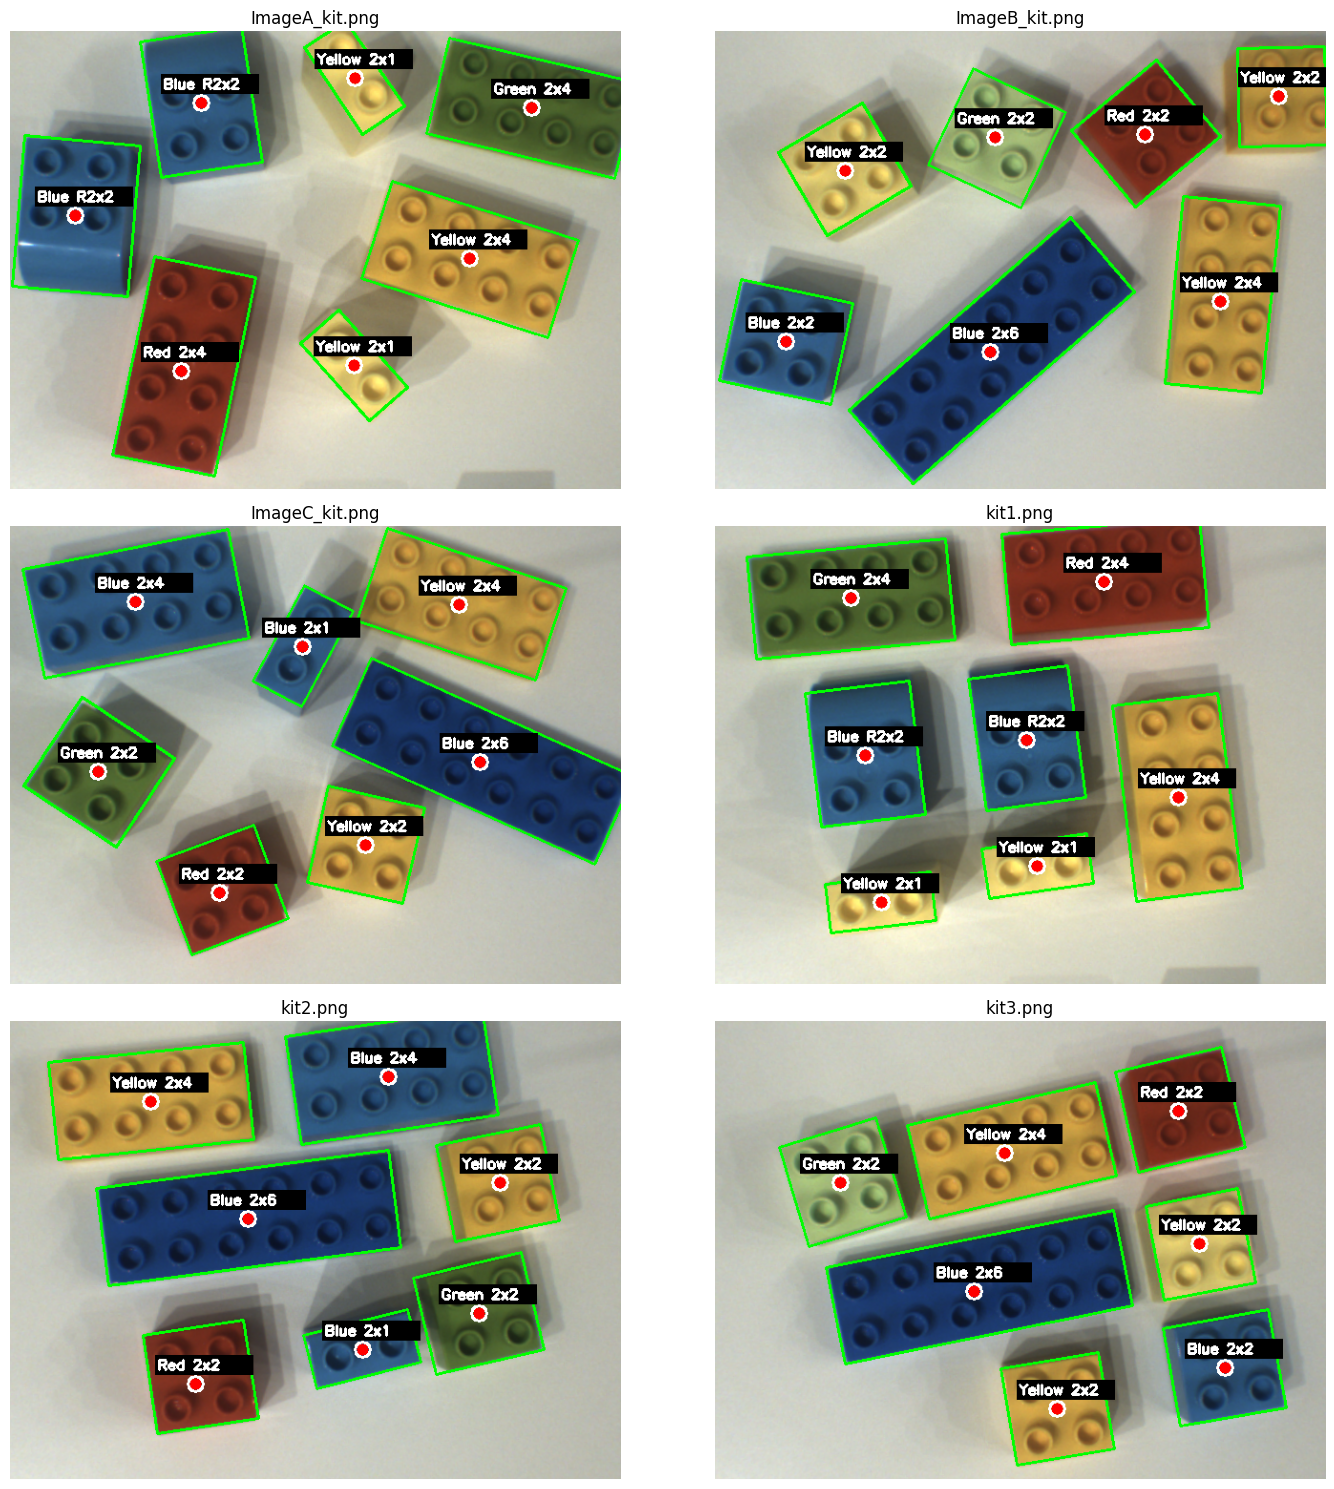

In [219]:
# color ranges
color_ranges = {
    'Red': [(0, 100, 100), (10, 255, 255)],
    'Red2': [(170, 100, 100), (180, 255, 255)],
    'Yellow': [(20, 120, 100), (30, 255, 255)],
    'Green': [(40, 50, 50), (80, 255, 255)],
    'Blue': [(85, 80, 80), (135, 255, 255)]
}

mm_per_pixel = 0.3298

kit_images = glob(f'{base_path}/Kit/*.png')

all_results = {}
result_images = []  # Store images for plotting

for image_path in sorted(kit_images):
    filename = image_path.split('/')[-1]
    print(f"\n{'='*60}")
    print(f"Processing: {filename}")
    print(f"{'='*60}")

    inventory, result_img, detected_bricks = analyze_kit_image_with_rotation(
        image_path, mtx, dist, color_ranges, mm_per_pixel, detect_white=False
    )

    if result_img is not None:
        all_results[filename] = {
            'inventory': inventory,
            'bricks': detected_bricks
        }

        # Store image and filename for plotting
        result_images.append((filename, result_img))

        # Print details
        print(f"\nDetected Bricks:")
        print("-" * 90)
        print(f"{'#':<4} {'Color':<10} {'Size':<8} {'Centroid':<18} {'Angle':<10} {'Dimensions (mm)'}")
        print("-" * 90)

        for i, brick in enumerate(detected_bricks, 1):
            cx, cy = brick['centroid']
            angle = brick['angle']
            w_mm, h_mm = brick['dimensions_mm']
            print(f"{i:<4} {brick['color']:<10} {brick['size']:<8} "
                  f"({cx:3d}, {cy:3d}){'':<6} {angle:6.1f}° {w_mm:.1f} x {h_mm:.1f}")

        print(f"\nTotal: {len(detected_bricks)} bricks")

# Plot all images in a grid
num_images = len(result_images)
cols = 2
rows = (num_images + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if num_images > 1 else [axes]  # Handle single image case

for idx, (filename, img) in enumerate(result_images):
    # Convert BGR to RGB for matplotlib
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(filename, fontsize=12)
    axes[idx].axis('off')

# Hide unused subplots
for idx in range(num_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## b)

In [220]:
print("\nTable 3: Brick inventory for each kit image")
print("-" * 55)

# Prepare a list to store all rows
table_rows = []

# Process each image's results
for image_name, results in all_results.items():
    inventory = results['inventory']

    #list of all bricks with their properties
    brick_list = []
    for size in ['2x1', '2x2', '2x4', '2x6', 'R2x2']:
        for color in ['Red', 'Yellow', 'Green', 'Blue', 'White']:
            count = inventory[size][color]
            if count > 0:
                brick_list.append({
                    'size': size,
                    'color': color,
                    'quantity': count
                })

    # Sort by size for consistent output
    brick_list.sort(key=lambda x: (x['size'], x['color']))

    # Print table rows & save to list
    for i, brick in enumerate(brick_list):
        image_col = image_name if i == 0 else ""

        print(f"{image_col:<20} {brick['size']:<8} {brick['color']:<10} {brick['quantity']:<10}")

        # Append to master table list
        table_rows.append({
            'image': image_name,
            'size': brick['size'],
            'color': brick['color'],
            'quantity': brick['quantity']
        })

    if brick_list:
        print()

print("-" * 55)

cv.destroyAllWindows()


Table 3: Brick inventory for each kit image
-------------------------------------------------------
ImageA_kit.png       2x1      Yellow     2         
                     2x4      Green      1         
                     2x4      Red        1         
                     2x4      Yellow     1         
                     R2x2     Blue       2         

ImageB_kit.png       2x2      Blue       1         
                     2x2      Green      1         
                     2x2      Red        1         
                     2x2      Yellow     2         
                     2x4      Yellow     1         
                     2x6      Blue       1         

ImageC_kit.png       2x1      Blue       1         
                     2x2      Green      1         
                     2x2      Red        1         
                     2x2      Yellow     1         
                     2x4      Blue       1         
                     2x4      Yellow     1         
             

## c)

In [221]:
df_bricks = pd.DataFrame(table_rows)

kits_df = df_bricks[df_bricks['image'].str.startswith('kit')]
images_df = df_bricks[~df_bricks['image'].str.startswith('kit')]

# dictionary for kit signatures
kit_signatures = {
    kit_name: make_signature(kits_df[kits_df['image'] == kit_name])
    for kit_name in kits_df['image'].unique()
}

# which kit matches each image
matches = []
for img_name in images_df['image'].unique():
    img_sig = make_signature(images_df[images_df['image'] == img_name])
    # the kit with identical signature
    for kit_name, kit_sig in kit_signatures.items():
        if img_sig == kit_sig:
            matches.append((img_name, kit_name))
            break

print("\nMATCH RESULTS")
print("-" * 40)
for img, kit in matches:
    print(f"{img:<20} --> {kit}")
print("-" * 40)



MATCH RESULTS
----------------------------------------
ImageA_kit.png       --> kit1.png
ImageB_kit.png       --> kit3.png
ImageC_kit.png       --> kit2.png
----------------------------------------


## d)


1. Improved Lighting Setup: Implement a consistent lighting with controlled
color temperature to eliminate/lower the shadows, also ensuring uniform illumination
across all bricks regardless of color.

2. Enhanced Camera Calibration: Use automated calibration checks or markers
on the work pipeline, allowing for continuous monitoring and real-time adjustment of
camera parameters to maintain accuracy.

3. Multi-angle Imaging System: Install multiple cameras at different angles to capture 3D information,
improving size classification accuracy and handling occluded or rotated bricks more effectively.

4. Optimized Background: Use a matte, neutral-colored background that contrasts with
all brick colors to simplify segmentation and eliminate the shadows that interfere with
accurate brick detection and color classification.

## 4. Fault images:

In [222]:
def load_reference_kits_from_images(kit_paths, mtx, dist, color_ranges, mm_per_pixel):
    """
    Load reference kits by analyzing the reference images (kitA.png, kitB.png, kitC.png)
    """
    reference_kits = {}

    print("\n" + "="*70)
    print("LOADING REFERENCE KITS")
    print("="*70)

    for kit_name, kit_path in kit_paths.items():
        print(f"\nAnalyzing reference {kit_name}: {kit_path}")

        inventory, result_img, detected_bricks = analyze_kit_image_with_rotation(
            kit_path, mtx, dist, color_ranges, mm_per_pixel, detect_white=False
        )

        # Save visualization
        output_path = f'4_kit_detection_{kit_name}.png'
        cv.imwrite(output_path, result_img)
        print(f"\n✓ Visualization saved: {output_path}")


        if inventory is None:
            print(f"  ❌ Error loading {kit_name}")
            continue

        reference_kits[kit_name] = inventory

        # Print reference kit contents
        print(f"\n{kit_name} specification:")
        print("-" * 50)
        total_bricks = 0
        for size in ['2x1', '2x2', 'R2x2', '2x4', '2x6']:
            for color in ['Red', 'Yellow', 'Green', 'Blue', 'White']:
                count = inventory[size][color]
                if count > 0:
                    print(f"  {color} {size}: {count}")
                    total_bricks += count
        print(f"  Total: {total_bricks} bricks")


    return reference_kits


def compare_with_reference_kits(detected_inventory, reference_kits):
    """
    Compare detected inventory with reference kits
    Returns best match, score, and detailed differences
    """
    best_match = None
    best_score = -1
    all_match_details = {}

    for kit_name, ref_inventory in reference_kits.items():
        exact_matches = 0
        total_expected = 0
        differences = []

        # Compare each size and color
        for size in ref_inventory.keys():
            for color in ref_inventory[size].keys():
                expected = ref_inventory[size][color]
                detected = detected_inventory[size][color]

                if expected > 0:
                    total_expected += expected

                    if detected == expected:
                        exact_matches += expected
                    elif detected < expected:
                        # Missing bricks
                        missing = expected - detected
                        exact_matches += detected  # Count what was found
                        differences.append({
                            'type': 'MISSING',
                            'brick': f"{color} {size}",
                            'expected': expected,
                            'detected': detected,
                            'difference': missing
                        })
                    else:
                        # Extra bricks
                        extra = detected - expected
                        exact_matches += expected  # Count expected amount
                        differences.append({
                            'type': 'EXTRA',
                            'brick': f"{color} {size}",
                            'expected': expected,
                            'detected': detected,
                            'difference': extra
                        })
                elif detected > 0:
                    # Brick not supposed to be in this kit
                    differences.append({
                        'type': 'UNEXPECTED',
                        'brick': f"{color} {size}",
                        'expected': 0,
                        'detected': detected,
                        'difference': detected
                    })

        # Calculate match percentage
        match_percentage = (exact_matches / total_expected * 100) if total_expected > 0 else 0

        all_match_details[kit_name] = {
            'score': match_percentage,
            'exact_matches': exact_matches,
            'total_expected': total_expected,
            'differences': differences
        }

        if match_percentage > best_score:
            best_score = match_percentage
            best_match = kit_name

    return best_match, best_score, all_match_details


def is_kit_faulty(differences):
    """
    Determine if a kit is faulty based on differences
    """
    return len(differences) > 0


def generate_fault_message(differences):
    """
    Generate formatted fault messages
    """
    messages = []

    for diff in differences:
        if diff['type'] == 'MISSING':
            messages.append(f"{diff['brick']} is missing (Expected {diff['expected']}, Found {diff['detected']})")
        elif diff['type'] == 'EXTRA':
            messages.append(f"{diff['brick']} has extra units (Expected {diff['expected']}, Found {diff['detected']})")
        elif diff['type'] == 'UNEXPECTED':
            messages.append(f"{diff['brick']} should not be in this kit (Found {diff['detected']})")

    return messages


LOADING REFERENCE KITS

Analyzing reference Kit A: /content/drive/MyDrive/PROJETO VC/ASSIGNMENT 1/assign1_data/Fault/kitA.png

✓ Visualization saved: 4_kit_detection_Kit A.png

Kit A specification:
--------------------------------------------------
  Yellow 2x1: 1
  Red 2x2: 1
  Yellow 2x2: 1
  Blue R2x2: 1
  Red 2x4: 1
  Green 2x4: 1
  Total: 6 bricks

Analyzing reference Kit B: /content/drive/MyDrive/PROJETO VC/ASSIGNMENT 1/assign1_data/Fault/kitB.png

✓ Visualization saved: 4_kit_detection_Kit B.png

Kit B specification:
--------------------------------------------------
  Yellow 2x1: 1
  Red 2x2: 1
  Yellow 2x2: 1
  Blue R2x2: 1
  Yellow 2x4: 1
  Green 2x4: 1
  Total: 6 bricks

Analyzing reference Kit C: /content/drive/MyDrive/PROJETO VC/ASSIGNMENT 1/assign1_data/Fault/kitC.png

✓ Visualization saved: 4_kit_detection_Kit C.png

Kit C specification:
--------------------------------------------------
  Yellow 2x2: 1
  Red 2x4: 1
  Yellow 2x4: 1
  Green 2x4: 1
  Blue 2x4: 1
  Blue 2x

/tmp/ipython-input-3652922956.py:128: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3652922956.py:128: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


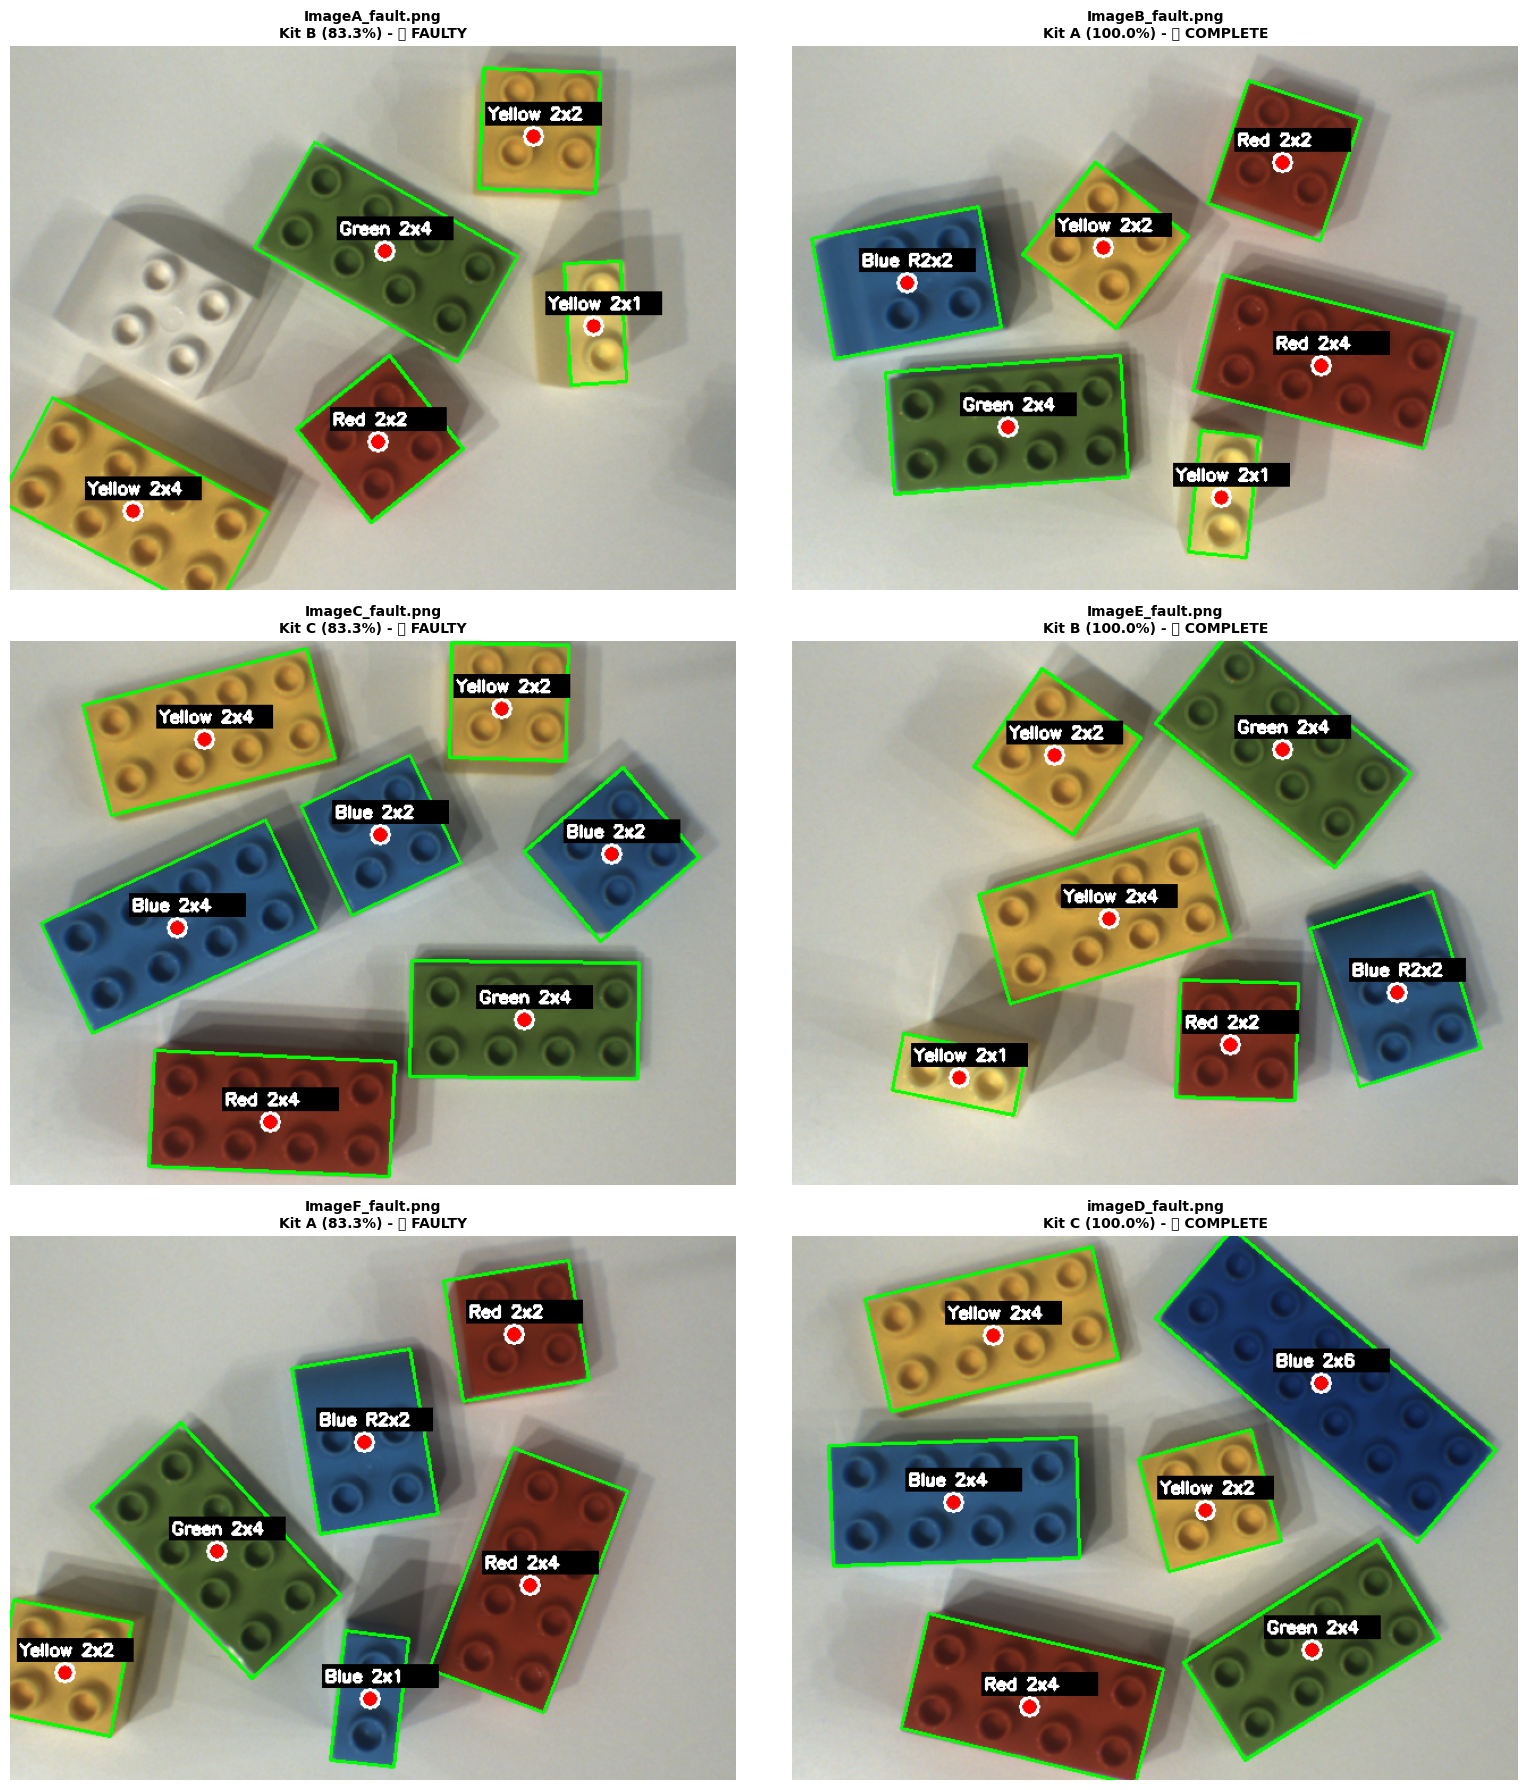


EXERCISE 4: SUMMARY TABLE

Image                               Matched Kit  Score      Status       Issues
--------------------------------------------------------------------------------
ImageA_fault.png                    Kit B          83.3%  ❌ FAULTY     1 issue(s)
ImageB_fault.png                    Kit A         100.0%  ✅ COMPLETE   0 issue(s)
ImageC_fault.png                    Kit C          83.3%  ❌ FAULTY     2 issue(s)
ImageE_fault.png                    Kit B         100.0%  ✅ COMPLETE   0 issue(s)
ImageF_fault.png                    Kit A          83.3%  ❌ FAULTY     2 issue(s)
imageD_fault.png                    Kit C         100.0%  ✅ COMPLETE   0 issue(s)

DETAILED FAULT REPORT

ImageA_fault.png (Matched to Kit B):
--------------------------------------------------------------------------------
  • Blue R2x2 is missing (Expected 1, Found 0)

ImageC_fault.png (Matched to Kit C):
--------------------------------------------------------------------------------
  • Blue 2x

In [223]:
# Paths to reference kit images
reference_kit_paths = {
    'Kit A': f'{base_path}/Fault/kitA.png',
    'Kit B': f'{base_path}/Fault/kitB.png',
    'Kit C': f'{base_path}/Fault/kitC.png'
}

# Same color ranges as exercise 3
color_ranges = {
    'Red': [(0, 100, 100), (10, 255, 255)],
    'Red2': [(170, 100, 100), (180, 255, 255)],
    'Yellow': [(19, 120, 172), (30, 255, 255)],
    'Green': [(40, 50, 50), (80, 255, 255)],
    'Blue': [(85, 80, 80), (135, 255, 255)]
}

mm_per_pixel = 0.3298

# Load reference kits from images
reference_kits = load_reference_kits_from_images(
    reference_kit_paths, mtx, dist, color_ranges, mm_per_pixel
)

# Analyze fault images
print("\n" + "="*80)
print("ANALYZING TEST IMAGES FROM FAULT FOLDER")
print("="*80)

fault_images = glob(f'{base_path}/Fault/*.png')
# Exclude reference kit images
fault_images = [f for f in fault_images
                if not any(ref in f for ref in ['kitA.png', 'kitB.png', 'kitC.png'])]

fault_results = {}
result_images = []  # Store images for plotting

for image_path in sorted(fault_images):
    filename = image_path.split('/')[-1]
    print(f"\n{'='*80}")
    print(f"Analyzing: {filename}")
    print(f"{'='*80}")

    # Detect bricks in the image
    inventory, result_img, detected_bricks = analyze_kit_image_with_rotation(
        image_path, mtx, dist, color_ranges, mm_per_pixel, detect_white=True
    )

    if result_img is None:
        print(f"❌ Error processing {filename}")
        continue

    # Print detected bricks
    print(f"\nDetected {len(detected_bricks)} bricks:")
    for brick in detected_bricks:
        print(f"  {brick['color']} {brick['size']}")

    # Compare with reference kits
    best_match, best_score, match_details = compare_with_reference_kits(
        inventory, reference_kits
    )

    # Get differences for best match
    differences = match_details[best_match]['differences']
    is_faulty = is_kit_faulty(differences)

    # Store results
    fault_results[filename] = {
        'best_match': best_match,
        'score': best_score,
        'is_faulty': is_faulty,
        'differences': differences,
        'inventory': inventory,
        'detected_bricks': detected_bricks
    }

    # Store image for plotting
    result_images.append((filename, result_img, best_match, best_score, is_faulty))

    # Print matching results
    print(f"\n" + "-"*80)
    print("KIT MATCHING RESULTS:")
    print("-"*80)
    for kit_name, details in match_details.items():
        marker = "-->" if kit_name == best_match else "  "
        print(f"{marker} {kit_name}: {details['score']:.1f}% match "
              f"({details['exact_matches']}/{details['total_expected']} bricks correct)")

    print(f"\n{'='*80}")
    print(f"BEST MATCH: {best_match} ({best_score:.1f}% confidence)")

    if is_faulty:
        print(f"STATUS: ❌ FAULTY KIT")
        print(f"\nFAULT DETAILS:")
        print("-" * 80)

        fault_messages = generate_fault_message(differences)
        for i, msg in enumerate(fault_messages, 1):
            print(f"  {i}. {msg}")
    else:
        print(f"STATUS: ✅ COMPLETE KIT - All bricks present and correct")

# =============================================================================
# PLOT ALL IMAGES IN A GRID
# =============================================================================

num_images = len(result_images)
cols = 2
rows = (num_images + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
axes = axes.flatten() if num_images > 1 else [axes]

for idx, (filename, img, best_match, score, is_faulty) in enumerate(result_images):
    # Convert BGR to RGB for matplotlib
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes[idx].imshow(img_rgb)

    # Create title with status
    status = "❌ FAULTY" if is_faulty else "✅ COMPLETE"
    title = f"{filename}\n{best_match} ({score:.1f}%) - {status}"
    axes[idx].set_title(title, fontsize=10, fontweight='bold')
    axes[idx].axis('off')

# Hide unused subplots
for idx in range(num_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY TABLE
# =============================================================================

print("\n" + "="*80)
print("EXERCISE 4: SUMMARY TABLE")
print("="*80)

print(f"\n{'Image':<35} {'Matched Kit':<12} {'Score':<10} {'Status':<12} {'Issues'}")
print("-" * 80)

for filename, result in sorted(fault_results.items()):
    status = "FAULTY" if result['is_faulty'] else "COMPLETE"
    status_symbol = "❌" if result['is_faulty'] else "✅"
    num_issues = len(result['differences'])

    print(f"{filename:<35} {result['best_match']:<12} {result['score']:>6.1f}%  "
          f"{status_symbol} {status:<10} {num_issues} issue(s)")

# Detailed fault report
print("\n" + "="*80)
print("DETAILED FAULT REPORT")
print("="*80)

for filename, result in sorted(fault_results.items()):
    if result['is_faulty']:
        print(f"\n{filename} (Matched to {result['best_match']}):")
        print("-" * 80)

        fault_messages = generate_fault_message(result['differences'])
        for msg in fault_messages:
            print(f"  • {msg}")

cv.destroyAllWindows()